In [38]:
import os
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
# From PDFInterpreter import both PDFResourceManager and PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
# Import this to raise exception whenever text extraction from PDF is not allowed
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.layout import LAParams, LTTextBox, LTTextLine
from pdfminer.converter import PDFPageAggregator

import re

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


# nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import pandas as pd
import seaborn as sns

In [2]:
''' This is what we are trying to do:
1) Transfer information from PDF file to PDF document object. This is done using parser
2) Get a list of PDF files (papers) from the Papers directory
3) For each PDF file, open and parse the file using PDFParser object
4) Assign the parsed content to PDFDocument object
5) Now the information in this PDFDocumet object has to be processed. For this we need
   PDFPageInterpreter, PDFDevice and PDFResourceManager
6) Finally process the file page by page 
'''

base_path = "C:\Users\Linh B Ngo\Google Drive\CloudLab2\Papers"
 
my_files = [f for f in os.listdir(base_path)]

# depending on operating system, you might have to modify this code to remove system files
my_files.remove('desktop.ini')
print (my_files)

['Active Learning in Performance Analysis.pdf', 'An information infrastructure framework for smart grids leveraging SDN and cloud.pdf', 'ARM Virtualization Performance and Architectural Implications.pdf', 'Brados Declarative Programmable Object Storage.pdf', 'CQSTR - Securing Cross\xacTenant Applications with Cloud Containers.pdf', 'High-Performance ACID via Modular Concurrency Control.pdf', 'JetStream ClusterScale Parallelization of Information Flow Queries.pdf', 'One Bit Flips One Cloud Flops Cross VM Row Hammer Attacks and Privilege Escalation.pdf', 'Paving the Way for NFV Simplifying Middlebox Modifications using StateAlyzr.pdf', 'Reproducible Scientific Computing Environment with Overlay Cloud Architecture - IEEE Conference Publication.pdf', 'SEINA - A Stealthy and Effective Internal Attack in Hadoop Systems.pdf', 'Self-configuring Software-defined Overlay Bypass for Seamless Inter and Intra-cloud Virtual Networking.pdf', 'Split-level IO scheduling.pdf', 'Subways - A Case for Redu

In [3]:
papers = []
papers_title = []

for f in my_files:
    password = ""
    extracted_text = ""    
    papers_title.append(f.split('.pdf', 1)[0].replace(' ','_'))
    
    print(f)
    fp = open(os.path.join(base_path, f), "rb")    
    parser = PDFParser(fp)    
    document = PDFDocument(parser, password)
    if not document.is_extractable:
        raise PDFTextExtractionNotAllowed    
    rsrcmgr = PDFResourceManager()
    laparams = LAParams()
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    # Ok now that we have everything to process a pdf document, lets process it page by page
    for page in PDFPage.create_pages(document):
        # As the interpreter processes the page stored in PDFDocument object
        interpreter.process_page(page)
        # The device renders the layout from interpreter
        layout = device.get_result()
        # Out of the many LT objects within layout, we are interested in LTTextBox and LTTextLine
        for lt_obj in layout:
            if isinstance(lt_obj, LTTextBox) or isinstance(lt_obj, LTTextLine):
                extracted_text += lt_obj.get_text()
    fp.close()
    
    # Some preliminary data cleaning
    extracted_text = extracted_text.lower()
    headless_text = extracted_text.split("abstract", 1)[1].split('introduction', 1)[1]
    final_text = headless_text.rsplit('references', 1)[0].replace('-\n','').replace('\n', ' ').replace(ur'\u201c', ' ').replace(ur'\u201d', ' ').replace(ur'\ufb01', 'fi').replace(ur'\u2022', ' ').replace(ur'\u2013', ' ')
    
    papers.append(final_text)

Active Learning in Performance Analysis.pdf
An information infrastructure framework for smart grids leveraging SDN and cloud.pdf
ARM Virtualization Performance and Architectural Implications.pdf
Brados Declarative Programmable Object Storage.pdf
CQSTR - Securing Cross�Tenant Applications with Cloud Containers.pdf
High-Performance ACID via Modular Concurrency Control.pdf
JetStream ClusterScale Parallelization of Information Flow Queries.pdf
One Bit Flips One Cloud Flops Cross VM Row Hammer Attacks and Privilege Escalation.pdf
Paving the Way for NFV Simplifying Middlebox Modifications using StateAlyzr.pdf
Reproducible Scientific Computing Environment with Overlay Cloud Architecture - IEEE Conference Publication.pdf
SEINA - A Stealthy and Effective Internal Attack in Hadoop Systems.pdf
Self-configuring Software-defined Overlay Bypass for Seamless Inter and Intra-cloud Virtual Networking.pdf
Split-level IO scheduling.pdf
Subways - A Case for Redundant, Inexpensive Data Center Edge Links.pd

In [23]:
NUM_TOPICS = 20
STOPWORDS = stopwords.words('english')
COMMONWORDS = ['cid:31','figure','two','cid:27', \
               'cid:29','also','cid:28','cid:30', \
               'cid:25','cid:26','performance','data', \
               'cid:24','cid:21','cid:22','cid:23', 'cid:20']

def clean_text(text):    
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if \
                        t not in STOPWORDS and \
                        t not in COMMONWORDS and \
                        re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return cleaned_text
 
# For gensim we need to tokenize the data and filter out stopwords
tokenized_data = []
for text in papers:
    tokenized_data.append(clean_text(text)) 

In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_data], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tokenized_data[0]]])

[u'active_learning', u'set', u'machine', u'learning', u'techniques', u'learner', u'interacts', u'source', u'learned', u'one', u'use', u'query', u'human', u'run', u'expensive', u'algorithm', u'label', u'datapoint', u'correct', u'labeling', u'difficult', u'predict', u'intuitively', u'learning', u'algorithm', u'makes', u'decisions', u'parts', u'space', u'know', u'enough', u'selectively', u'invokes', u'expensive', u'process', u'gather', u'supporting', u'make', u'predictions', u'area', u'type', u'learning', u'typically', u'applied', u'classification', u'problems', u'described', u'authors', u'emphasize', u'limited', u'number', u'studies', u'investigated', u'applied', u'regression', u'problems', u'study', u'apply', u'techniques', u'regression', u'problems', u'creating', u'regression', u'models', u'energy_consumption', u'parallel', u'computing', u'experiments', u'setting', u'goal', u'take', u'existing', u'empirical', u'studies', u'hpc', u'codes', u'perform', u'regression', u'analysis', u'disco

In [25]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [26]:
# Form Bigrams
data_words_bigrams = make_bigrams(tokenized_data)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[[u'active_learn', u'set', u'machine', u'learning', u'technique', u'learner', u'interacts', u'source', u'learn', u'use', u'query', u'human', u'run', u'expensive', u'algorithm', u'label', u'datapoint', u'correct', u'labeling', u'difficult', u'predict', u'intuitively', u'learn', u'algorithm', u'make', u'decision', u'part', u'space', u'know', u'enough', u'selectively', u'invoke', u'expensive', u'process', u'gather', u'support', u'make', u'prediction', u'area', u'type', u'learning', u'typically', u'apply', u'classification', u'problem', u'describe', u'author', u'emphasize', u'limited', u'number', u'study', u'investigate', u'apply', u'regression', u'problem', u'study', u'apply', u'technique', u'regression', u'problem', u'create', u'regression', u'model', u'parallel', u'computing', u'experiment', u'setting', u'goal', u'take', u'exist', u'empirical', u'study', u'hpc', u'code', u'perform', u'regression', u'analysis', u'discover', u'relationship', u'controlled_variable', u'size', u'problem', u'

In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [28]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=NUM_TOPICS, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=200,
                                           alpha='auto',
                                           per_word_topics=True)

In [29]:
print("LDA Model:")

for idx in range(NUM_TOPICS):
    # print("Topic #%s:" % idx, lda_model.print_topic(idx, 25))
    # print without probability
    tmp_topics = ''
    for term in lda_model.get_topic_terms(idx, 25):
        tmp_topics += id2word.get(term[0]) + '; '
    print('Topic #%s:' % idx, tmp_topics)    

LDA Model:
('Topic #0:', u'gember; gao; func; ful; ftmb; frameworkindependent; frameworkcompliant; forwardslice; forward/backward; formalparams; formal; extractflowspace; foreach; foo; flowspaces; flowspace; flags; flag; fisher; ferrante; fault_tolerance; fashion; getiphdr; forcibly; hashtable; ')
('Topic #1:', u'gember; gao; func; ful; ftmb; frameworkindependent; frameworkcompliant; forwardslice; forward/backward; formalparams; formal; extractflowspace; foreach; foo; flowspaces; flowspace; flags; flag; fisher; ferrante; fault_tolerance; fashion; getiphdr; forcibly; hashtable; ')
('Topic #2:', u'task; interface; attack; execution; system; use; object; design; storage; ceph; job; time; value; node; operation; hadoop; delay; show; write; log; corfu; implementation; epoch; application; metadata; ')
('Topic #3:', u'server; tor; epoch; query; use; rack; type; time; network; jetstream; dift; set; switch; first; core; cluster; source; show; global_source; subway; aggregation; traffic; link; d

In [30]:
title_idx = 0
for text in papers:
    print('Topics for paper %s: ' % papers_title[title_idx], lda_model.get_document_topics(id2word.doc2bow(clean_text(text))))
    title_idx += 1

('Topics for paper Active_Learning_in_Performance_Analysis: ', [(3, 0.024146276), (6, 0.019061731), (8, 0.039046187), (11, 0.81226957), (17, 0.046579316), (19, 0.032673948)])
('Topics for paper An_information_infrastructure_framework_for_smart_grids_leveraging_SDN_and_cloud: ', [(3, 0.03291969), (5, 0.015937822), (11, 0.013568592), (17, 0.011336668), (19, 0.9070266)])
('Topics for paper ARM_Virtualization_Performance_and_Architectural_Implications: ', [(2, 0.01756637), (3, 0.019579869), (5, 0.023415608), (6, 0.019383088), (7, 0.86274135), (11, 0.010103326), (17, 0.011825816), (19, 0.028132662)])
('Topics for paper Brados_Declarative_Programmable_Object_Storage: ', [(2, 0.8748026), (6, 0.033324488), (7, 0.010459414), (11, 0.021287668), (17, 0.014758801), (19, 0.018978037)])
('Topics for paper CQSTR_-_Securing_Cross\xacTenant_Applications_with_Cloud_Containers: ', [(2, 0.01562841), (6, 0.011470158), (7, 0.043546543), (11, 0.016710794), (19, 0.8725984)])
('Topics for paper High-Performanc

In [31]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

('\nPerplexity: ', -7.109019925969584)
('\nCoherence Score: ', 0.5754117967102238)


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
# pyLDAvis.prepare(topic_term_dists, doc_topic_dists, 
# doc_lengths, vocab, term_frequency, 
# R=30, lambda_step=0.01, mds=<function js_PCoA>, n_jobs=-1, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, sort_topics=True)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics = False)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       0.000041        1       1  0.207917 -0.033081
1      17.973608        1       2 -0.094603 -0.007018
2      15.891244        1       3 -0.102480  0.025226
3       7.568278        1       4 -0.021401 -0.007815
4       7.835166        1       5 -0.028958  0.142209
5      14.851610        1       6 -0.062785 -0.156266
6      11.673901        1       7  0.001312  0.101725
7       4.532948        1       8 -0.002808  0.062809
8      19.673174        1       9 -0.104111 -0.094709
9       0.000032        1      10  0.207917 -0.033081, topic_info=     Category        Freq                 Term       Total  loglift  logprob
term                                                                        
2959  Default  254.000000          transaction  254.000000  30.0000  30.0000
4779  Default  157.000000                  tor  157.000000  29.0000  29.0000
3757  Default  303.000000               server  303.000000  28.0000  28.0000
5161  Default  155.000000                 copy  155.000000  27.0000  27.0000
522   Default  260.000000            container  260.000000  26.0000  26.0000
4192  Default  371.000000                cloud  371.000000  25.0000  25.0000
2191  Default  182.000000                epoch  182.000000  24.0000  24.0000
5061  Default  324.000000               memory  324.000000  23.0000  23.0000
6123  Default  116.000000               record  116.000000  22.0000  22.0000
3548  Default  153.000000                group  153.000000  21.0000  21.0000
5604  Default  154.000000                  arm  154.000000  20.0000  20.0000
2993  Default  169.000000                 page  169.000000  19.0000  19.0000
2821  Default  233.000000               attack  233.000000  18.0000  18.0000
1206  Default   93.000000                 rack   93.000000  17.0000  17.0000
157   Default  223.000000              service  223.000000  16.0000  16.0000
4149  Default  187.000000                  bit  187.000000  15.0000  15.0000
5373  Default   88.000000                calla   88.000000  14.0000  14.0000
1667  Default  352.000000              network  352.000000  13.0000  13.0000
5808  Default  162.000000           hypervisor  162.000000  12.0000  12.0000
380   Default  138.000000             variable  138.000000  11.0000  11.0000
4121  Default  176.000000                 task  176.000000  10.0000  10.0000
1467  Default  158.000000                  xen  158.000000   9.0000   9.0000
1404  Default  162.000000               packet  162.000000   8.0000   8.0000
5129  Default  235.000000                state  235.000000   7.0000   7.0000
5541  Default   99.000000                 vias   99.000000   6.0000   6.0000
3002  Default  139.000000              overlay  139.000000   5.0000   5.0000
1804  Default   72.000000                  nic   72.000000   4.0000   4.0000
3537  Default  159.000000               switch  159.000000   3.0000   3.0000
3134  Default  189.000000                 type  189.000000   2.0000   2.0000
76    Default  162.000000              feature  162.000000   1.0000   1.0000
...       ...         ...                  ...         ...      ...      ...
6152  Topic10    0.000004              expands    1.692862   1.9377  -8.7247
1922  Topic10    0.000004                afosr    1.687095   1.9411  -8.7247
2044  Topic10    0.000004            provision   12.069268  -0.0266  -8.7247
2045  Topic10    0.000004              discuss   44.034592  -1.3209  -8.7247
2046  Topic10    0.000004              lineage    1.687095   1.9411  -8.7247
2047  Topic10    0.000004             layering    1.692862   1.9377  -8.7247
2048  Topic10    0.000004            inversion    1.692862   1.9377  -8.7247
2049  Topic10    0.000004  logistic_regression    7.262779   0.4813  -8.7247
2050  Topic10    0.000004              january    1.697469   1.9350  -8.7247
2051  Topic10    0.000004                 drop   23.228441  -0.6813  -8.724

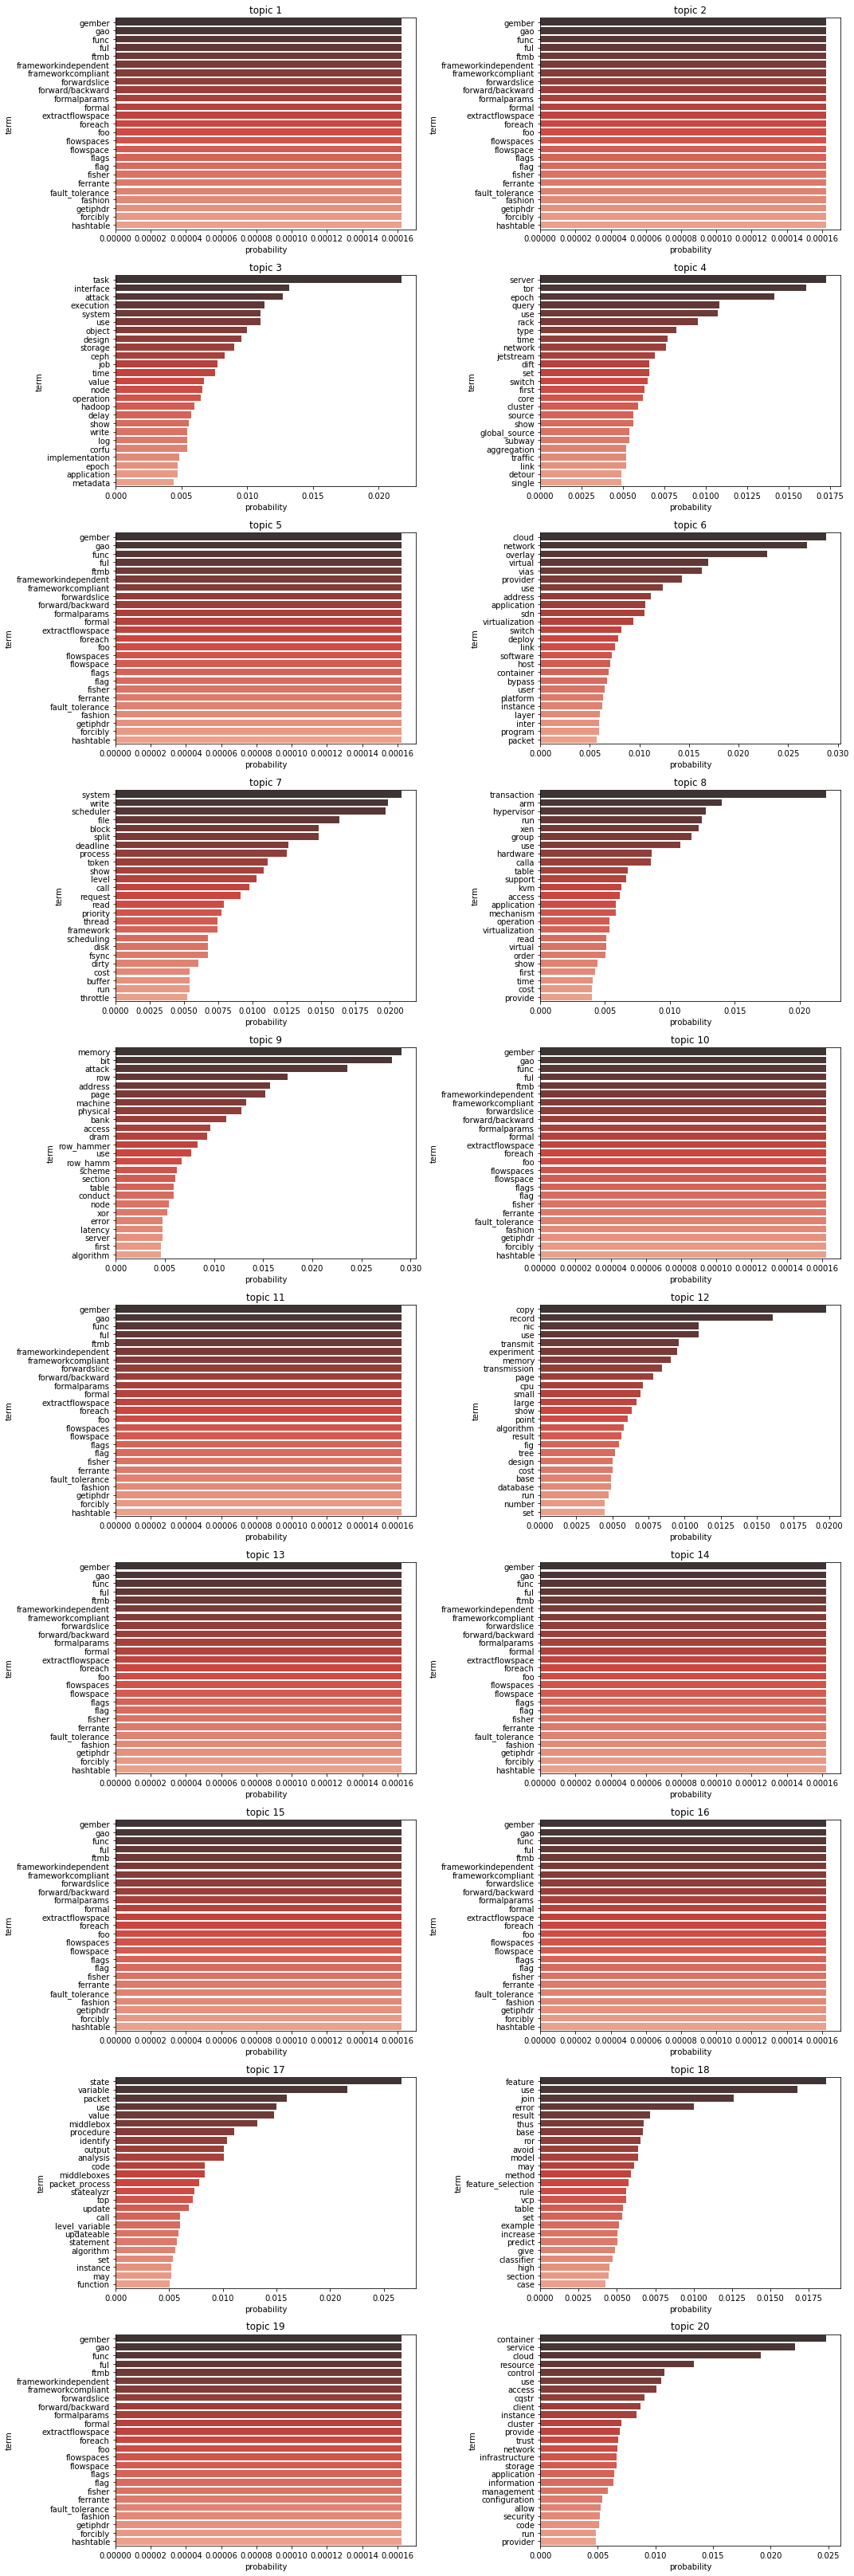

In [47]:
fiz=plt.figure(figsize=(15,45))
for i in range(NUM_TOPICS):
    df=pd.DataFrame(lda_model.show_topic(i, 25), columns=['term','prob']).set_index('term')
#     df=df.sort_values('prob')
    
    plt.subplot(10,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Reds_d')
    plt.xlabel('probability')
plt.tight_layout()
plt.show()

In [45]:
lda_model.show_topic(0, 25)

[(u'gember', 0.00016252235),
 (u'gao', 0.00016252235),
 (u'func', 0.00016252235),
 (u'ful', 0.00016252235),
 (u'ftmb', 0.00016252235),
 (u'frameworkindependent', 0.00016252235),
 (u'frameworkcompliant', 0.00016252235),
 (u'forwardslice', 0.00016252235),
 (u'forward/backward', 0.00016252235),
 (u'formalparams', 0.00016252235),
 (u'formal', 0.00016252235),
 (u'extractflowspace', 0.00016252235),
 (u'foreach', 0.00016252235),
 (u'foo', 0.00016252235),
 (u'flowspaces', 0.00016252235),
 (u'flowspace', 0.00016252235),
 (u'flags', 0.00016252235),
 (u'flag', 0.00016252235),
 (u'fisher', 0.00016252235),
 (u'ferrante', 0.00016252235),
 (u'fault_tolerance', 0.00016252235),
 (u'fashion', 0.00016252235),
 (u'getiphdr', 0.00016252235),
 (u'forcibly', 0.00016252235),
 (u'hashtable', 0.00016252235)]